# Dimensionaliteitsreductie

@author: Jan Verwaeren - Arne Deloose

@course: Machine learning: van theorie tot praktijk

Deze notbook bevat enkele illustraties van frequent gebruikte dimensionaliteitsreductietechnieken:
- (kernel) principale componenten analyse
- (metric) Multidimensional scaling


## 1. ILLUSTRATIE: (kernel) principale componenten analyse (PCA)

******

In deze sectie wordt PCA geïllustreerd op enkele datasets. We gebruiken daarbij de.

- iris dataset
- olympic dataset

**Inladen nodige libraries en enkele handige visualisatiefuncties**

In [2]:
import pandas as pd                                # pandas dataframes
import numpy as np                                 # numpy datastructuur voor homogene arrays (matrices)
from sklearn.preprocessing import StandardScaler   # scikit learn: tools voor standaardiseren data (gemiddelde=0 en stdev=1)
from sklearn.decomposition import PCA, KernelPCA   # scikit learn: klasses voor (kernel)PCA
from sklearn.manifold import TSNE                  #TSNE

import matplotlib.pyplot as plt                    # visualisatiebibliotheken
import plotnine
from plotnine import *
from plotnine.data import *

!pip install jellyfish
import jellyfish #lev afstand

#zelf gedefinieerde functies

def scree_plot(pca_model):
    """ genereert scree plot op basis van een gefit PCA model (argument is PCA-object, na fitten) """
    PC_values = np.arange(pca_model.n_components_) + 1
    plt.plot(PC_values, pca_model.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    return()

def biplot_func(score, pca_model, labels=None, y=None, show_index=False):
    """ genereert biplot, met argumenten:
         - score: de scores (twee eerste PC) die men wenst te visualiseren
         - pca_model: PCA-object, na fitten
         - labels: labels van PCs die als naam worden weergegeven
         - y: numerical vector, length equal to the number of observations used for color-coding the datapoints
         - show_index: geeft aan of de indices van de objecten bij de scores worden getoond
    """
    coeff=np.transpose(pca_model.components_[0:2, :]).copy()
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    coeff[:, 0] = coeff[:,0]*xs.std()*np.sqrt(len(xs))
    coeff[:, 1] = coeff[:,1]*ys.std()*np.sqrt(len(ys))
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c = y) #use y as color
    if show_index:
        for i in range(len(xs)):
            ax.text(xs[i], ys[i], i+1)
    if not y is None:
        fig.colorbar(im, ax=ax)
    for i in range(n):
        ax.arrow(0, 0, coeff[i, 0], coeff[i,1], color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(1.1*coeff[i,0], 1.1*coeff[i,1], "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            ax.text(1.1*coeff[i,0], 1.1*coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')           
    ax.set_xlim(1.2*min(np.min(coeff[:, 0]), np.min(xs)), 1.2*max(np.max(coeff[:, 0]), np.max(xs)))
    ax.set_ylim(1.2*min(np.min(coeff[:, 1]), np.min(ys)), 1.2*max(np.max(coeff[:, 1]), np.max(ys)))
    ax.set_xlabel("PC{}".format(1))
    ax.set_ylabel("PC{}".format(2))
    ax.grid()
    return(fig, ax)

You should consider upgrading via the 'c:\users\adloose\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


**STAP 1: Inladen iris dataset**

In [3]:
url='https://raw.githubusercontent.com/ArneDeloose/Ugain_MachineLearning_DataVis/main/iris.csv' #raw github link
df=pd.read_csv(url, sep = ";")
df.head()

,sepal length,sepal width,petal length,petal width,soort
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


**STAP 2: Extraheren numerieke variabelen en schalen van de data**

In [4]:
X = np.array(df.iloc[:,:4])
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)      # gemiddelde 0 en stdev 1 voor elke variabele

**STAP 3: Toepassen PCA**

In [5]:
pca_model = PCA()                   # genereren PCA object
x_new = pca_model.fit_transform(X)  # berekenen scores en loadings (x_new bevat de scores, de loadings kan je terugvinden
                                    # in pca_model.components_)

**STAP 4: Visualiseren scores**

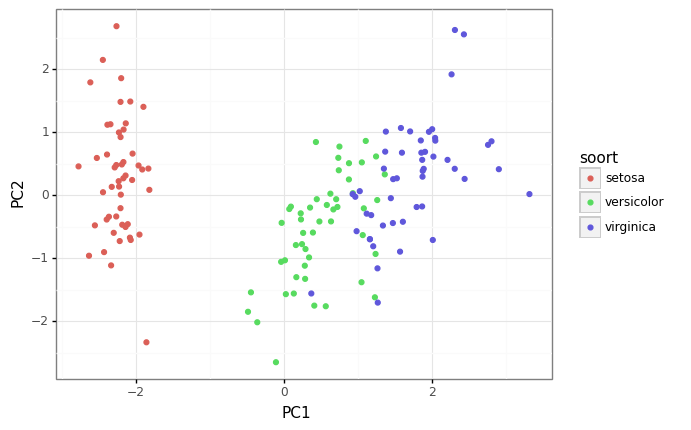

<ggplot: (-9223371915572768304)>

In [6]:
# PCA scores en soort-labels samenvatten in een pandas dataframe
df_pca = pd.DataFrame(x_new[:, 0:2], columns = ["PC1", "PC2"])
df_pca["soort"] = df["soort"]

# visualisatie met ggplot/plotnine
ggplot(df_pca, aes(x = "PC1", y = "PC2", color = "soort")) +\
    geom_point() +\
    theme_bw()

**STAP 5: bekijken loadings**

In [7]:
# wrappen van loadings en variabelenamen in dataframe
df_pca_loadings = pd.DataFrame(np.transpose(pca_model.components_[0:2, :]),
                               columns = ["PC1", "PC2"])
df_pca_loadings["variabelen"] = df.columns[:-1]
df_pca_loadings

,PC1,PC2,variabelen
0,0.521066,0.377418,sepal length
1,-0.269347,0.923296,sepal width
2,0.580413,0.024492,petal length
3,0.564857,0.066942,petal width


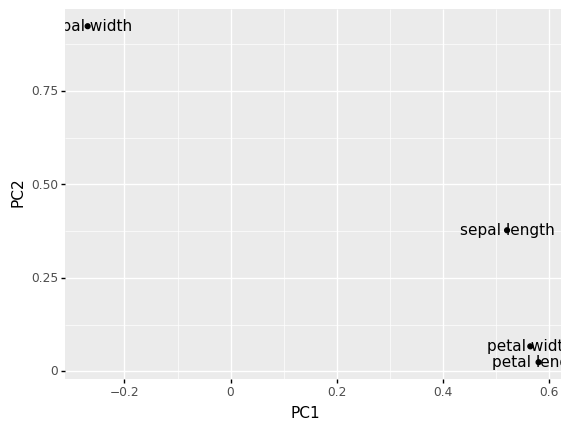

<ggplot: (-9223371915571696008)>

In [8]:
# visualiseren loadings
ggplot(df_pca_loadings, aes(x = "PC1", y = "PC2")) +\
   geom_point() +\
   geom_text(aes(label = "variabelen"))

**STAP 6: combineren scores en loadings op 1 plot: de biplot**

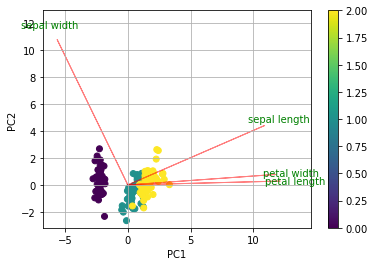

In [9]:
# optional: recode 'soort' naar numerieke vector, met 'setosa' = 0, 'versicolor' = 1, 'virginica' = 2
soort_recoded = np.unique(df["soort"], return_inverse = True)[1]

[fig, ax] = biplot_func(x_new[:, 0:2],
                        pca_model,
                        labels=df.columns[:-1],
                        y = soort_recoded,
                        show_index=False)

**STAP 7: bekijken verklaarde variabiliteit per PC**

()

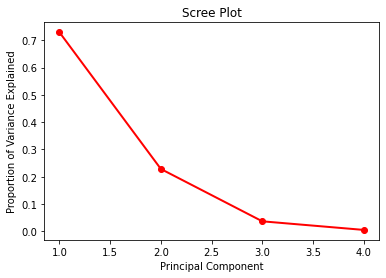

In [10]:
scree_plot(pca_model)

## 2. Oefeningen PCA

********

**1. Zware metalen in de Schelde**

Aan het departement omgeving onderzochten enkele onderzoekers de vervuiling van grasland
in de nabijheid van de rivier de Schelde. De concentratie van acht zware metalen (cadmium,
chroom, koper, ijzer, mangaan, nikkel, lood, zink) werd gemeten op 19 verschillende locaties
elke keer op een diepte van 5 en 20 cm. De nabijheid van de locatie tot de rivier werd genoteerd
als ver(0) of dicht(1). Je vindt de data terug in **heavymetals.csv**.

**1.1. Lees de data in en bestudeer ze zodat je er voeling mee krijgt.**

In [11]:
url='https://raw.githubusercontent.com/ArneDeloose/Ugain_MachineLearning_DataVis/main/heavymetals.csv'

df=pd.read_csv(url)
df.head()

,location,Cd5,Cd20,Cr5,Cr20,Cu5,Cu20,Fe5,Fe20,Mn5,Mn20,Ni5,Ni20,Pb5,Pb20,Zn5,Zn20,river
0,1,11.985549,10.248267,222.626423,201.704108,53.073686,47.127967,21082.422949,21115.642286,560.694658,539.509975,26.564668,28.185780,125.561693,110.016628,669.780898,566.873880,1
1,2,18.879780,21.305590,380.835214,472.996839,87.105354,98.220062,26086.565207,27674.416450,585.173876,439.722016,30.230354,31.932810,228.326793,249.615777,1308.674304,1500.207461,1
2,3,18.596573,25.293862,367.931598,471.080071,85.195973,99.346959,26505.513017,28401.947875,496.138010,492.556233,29.315192,32.593912,242.454283,271.708647,1338.875830,1579.756162,1
3,4,29.266197,28.375580,509.721009,536.508923,81.332707,107.378701,26227.868930,31017.349203,507.927708,445.994337,29.815369,35.302712,220.862755,283.042973,1311.174316,1696.887110,1
4,5,27.338299,16.642950,459.452164,374.883073,80.171948,89.435765,26673.331334,25223.073606,492.952114,375.191561,30.209437,30.453776,240.267920,256.055329,1356.359759,1399.907122,1


**1.2. Voer een PCA-analyse uit. Schaal je de data of niet? Hoeveel componenten zou je behouden?**

Data schalen kan je doen via:

- `scaler = StandardScaler()`

- `scaler.fit(X)`

- `X=scaler.transform(X)`


()

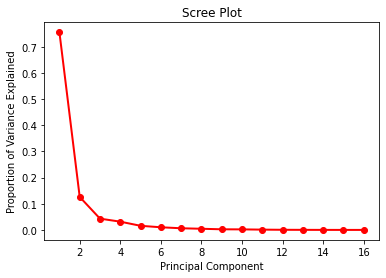

In [12]:
X=df.loc[:, 'Cd5':'Zn20']
y=df.loc[:, 'river']

#schalen?
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

#PCA fitten
pca_model = PCA()
x_new = pca_model.fit_transform(X)

#hoeveel componenten heb je nodig?
scree_plot(pca_model)

**1.3. Maak een biplot en interpreteer deze. Kleur de locaties in de biplot volgens de nabijheid bij de rivier.**

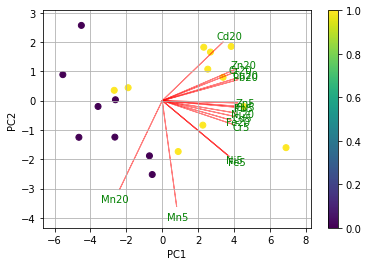

In [13]:
# 1.3. biplot
[fig, ax] = biplot_func(x_new[:, 0:2], pca_model, 
                        labels=df.loc[:, 'Cd5':'Zn20'].columns,  y=y)

**2. Gestrande dolfijnen**

Van een aantal gestrande dolfijnen aan de Schotse kusten, heeft men de vetzurensamenstelling
van hun vetlaag bestudeerd. De samenstelling - en dan vooral de hoeveelheid kortere versus
langere en onverzadigde versus verzadigde vetzuren - kan namelijk een indicatie zijn voor het
dieet van de dolfijnen. Voor meer dan 20 vetzuren werd de aanwezige concentratie bepaald. Je
kan de data terugvinden in **dolfijnen.csv**.

Vetzuren zijn genoteerd als FAxx.yy. De xx staat voor het aantal koolstofatomen in de vetzuurketen. De yy geeft het aantal dubbele bindingen weer. Verzadigde vetzuren hebben er geen,
dus daar is yy gelijk aan nul. Onverzadigde vetzuren worden genoteerd als an.b, waarbij a
het aantal dubbele bindingen geeft, en b het eerste koolstofatoom waar een dubbele binding
voorkomt (telkens te tellen van het uiteinde, niet de -COOH kop).
Dus bvb FA20.4n.3 is een onverzadigd vetzuur met een koolstofketen van 20 koolstofatomen
en 4 dubbele bindingen (telkens gescheiden door een CH2) die beginnen op positie 3.

**2.1. Lees de data in en bestudeer ze zodat je er voeling mee krijgt.**

In [14]:
url='https://raw.githubusercontent.com/ArneDeloose/Ugain_MachineLearning_DataVis/main/dolfijnen.csv'

df=pd.read_csv(url)
df.head()

,FA12.0,FA14.0,FA14.1.n.5,FA15.0,FA16.0,FA16.1n.7,FA16.2n.6,FA16.3n.6,FA16.4n.3,FA18.0,...,FA20.3,FA20.4n.3,FA20.5n.3,FA22.0,FA22.1n.11,FA22.1n.9,FA21.5n.3,FA22.5n.3,FA22.6n.3,FA24.1n.9
0,0.75,8.08,1.64,0.54,8.33,15.62,0.52,0.64,0.21,1.54,...,0.13,1.14,4.37,0.11,6.24,0.28,0.24,2.58,8.95,0.10
1,0.28,3.03,0.33,0.43,9.36,9.87,0.22,0.13,0.10,2.38,...,0.19,1.11,8.67,0.04,1.75,0.18,0.38,7.55,18.83,0.24
2,0.80,5.49,0.60,0.45,8.84,11.04,0.60,0.28,0.39,1.99,...,0.11,1.18,6.85,0.02,4.57,0.23,0.40,4.56,13.69,0.22
3,0.92,6.22,1.39,0.55,7.46,13.80,0.54,0.22,0.33,1.88,...,0.12,1.08,5.35,0.07,4.96,0.17,0.33,4.17,13.42,0.22
4,1.02,6.59,1.82,0.47,8.50,19.33,0.80,0.24,0.28,1.55,...,0.11,0.82,4.87,0.03,3.25,0.00,0.23,2.17,9.71,0.18


**2.2. Voer een PCA-analyse uit. Hoeveel dimensies zou je behouden om deze data voor te stellen?**

()

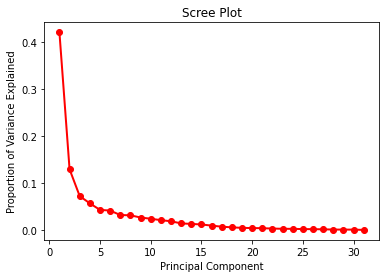

In [15]:
X=df

# scale data and fit pca
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

#PCA model fitten
pca_model = PCA()
x_new = pca_model.fit_transform(X)

#hoeveel componenten heb je nodig?
scree_plot(pca_model)

**2.3. Interpreteer de eerste component. Bekijk hiervoor de nodige diagnostische grafieken voor de eerste twee dimensies. Kijk ook eens naar de loadings voor de verschillende vetzuren.**

In [16]:
df_pc=pd.DataFrame()
df_pc['PC1']=pca_model.components_[0, :] #eerste component
df_pc['PC2']=pca_model.components_[1, :] #tweede component
df_pc['FA']=df.columns #naam van de vetzuren
df_pc #toon de dataframe

,PC1,PC2,FA
0,-0.228194,-0.134454,FA12.0
1,-0.241140,-0.131242,FA14.0
2,-0.232184,0.165669,FA14.1.n.5
3,-0.160834,-0.267374,FA15.0
4,-0.046661,0.080202,FA16.0
5,-0.235143,0.214908,FA16.1n.7
6,-0.080997,-0.279933,FA16.2n.6
7,-0.005940,-0.046879,FA16.3n.6
8,0.157522,-0.125422,FA16.4n.3
9,0.240463,-0.020633,FA18.0


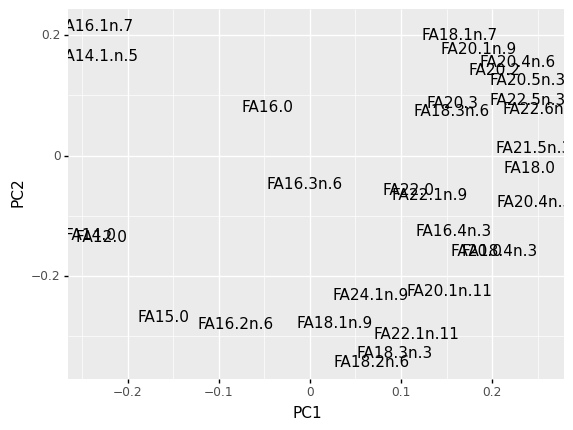

<ggplot: (-9223371915571553460)>

In [17]:
#plot
(
ggplot(aes(x='PC1', y='PC2'), data=df_pc)
+ geom_text(aes(label='FA'))
)

**2.4. Er bevinden zich 4 dolfijnen in de dataset die doodgeboren zijn, kan je hen identificeren?**

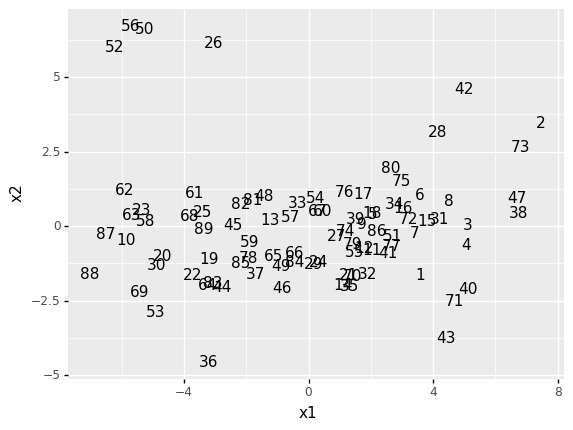

<ggplot: (-9223371915571490760)>

In [18]:
#plotnine
df_score=pd.DataFrame()
df_score['x1']=x_new[:, 0] #eerste component
df_score['x2']=x_new[:, 1] #tweede component
df_score['index']=range(1, len(x_new)+1)

(
ggplot(aes(x='x1', y='x2'), data=df_score)
+ geom_text(aes(label='index'))
)

**EXTRA: 2.5. herhaal de vraag in 2.4 met een kernel-pca (polynomiale kernel). Bekom je hetzelfde resultaat?**

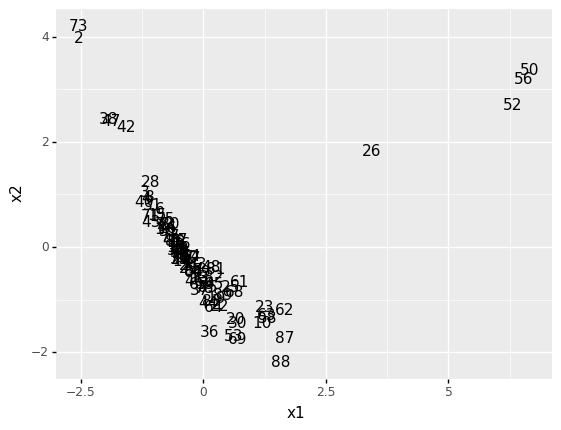

<ggplot: (-9223371915571765232)>

In [19]:
#kernel pca
from sklearn.decomposition import KernelPCA

pca_model = KernelPCA(kernel='poly')
x_new = pca_model.fit_transform(X)

df_score=pd.DataFrame()
df_score['x1']=x_new[:, 0] #eerste component
df_score['x2']=x_new[:, 1] #tweede component
df_score['index']=range(1, len(x_new)+1)

(
ggplot(aes(x='x1', y='x2'), data=df_score)
+ geom_text(aes(label='index'))
)

## 3. ILLUSTRATIE: Multidimensional scaling (MDS)

*****

In de onderstaande sectie wordt het gebruik van Multdimensional Scaling (MDS geïllustreerd).

**STEP 1**: import libraries

MDS is an example of what is generally known as manifold learning techniques. Therefore, it can be found in the `manifold` submodule of the `sklearn` package. The implementation of MDS in `sklearn` (and in particular the optimization routine behind it) relies on stress majorization, a brief description can be found [here](https://en.wikipedia.org/wiki/Stress_majorization). The documentation page of `sklearn` contains other manifold learning techniques, an overview kan be found [here](https://scikit-learn.org/stable/modules/manifold.html).

In [20]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_text, theme_bw
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

**STEP 2**: create distance matrix

A distance matrix is a square symmetric numpy array (dimensions equal the number of objects in the dataset). In the example below, the distance matrix is hand-coded, but in most cases it is the result of some distance computation. In most applications of MDS, choosing a good distance measure (that is relevant to the problem at hand) is key to the succes of MDS. 

In [21]:
D = np.array([[0, 1, 2, 3],
              [1, 0, 1, 2],
              [2, 1, 0, 2],
              [3, 2, 2, 0]])

**STEP 3**: apply MDS (follows the typical workflow of sklearn). 

We need to provide the MDS model: (1) the number of components to use; and (2) the type of distance matrix to use. For the latter, the default is Euclidean distance, assuming that the data is a traditional table (note that if Euclidean distance is used an a regular data-table such as the iris dataset is provided as input, the result would be almost identical to PCA). In this case, however, we want to provide a precomputed distance matrix.

In [22]:
MDS_model = MDS(n_components=2, 
                dissimilarity='precomputed')
MDS_model.fit_transform(D)

array([[ 1.39402867, -0.22111597],
       [ 0.33360396, -0.1894992 ],
       [-0.52434116, -0.74358433],
       [-1.20329147,  1.1541995 ]])

**STEP 4**: wrap results in a pandas dataframe

The attribute `embedding_` contains the computed coordinates. In the example below, they are extracted and wrapped into a Pandas dataframe with column names PC1 and PC2. An additional column is added as an identifier (note that this is not stricly necessary as Pandas dataframes automatically assign an index).

In [23]:
df = pd.DataFrame(MDS_model.embedding_,
                  columns = ["PC1", "PC2"])
df["idx"] = range(1, 5)

**STEP 5**: plot coordinates

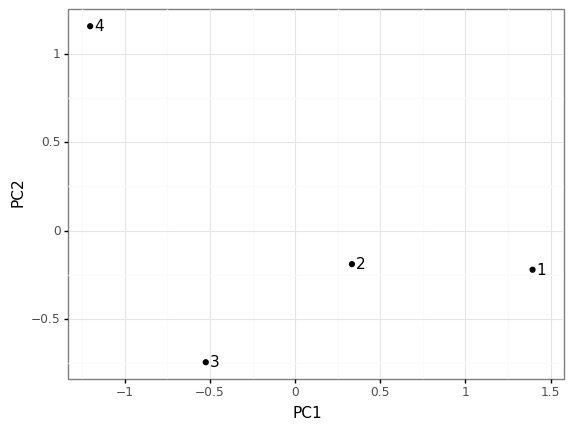

<ggplot: (-9223371915578687112)>

In [24]:
ggplot(df, aes(x = "PC1", y = "PC2")) +\
   geom_point() +\
   geom_text(aes(label = "idx"), nudge_x = 0.05) +\
   theme_bw()

**STEP 6**: look at the stress & do a check

In [25]:
print("stres: ", MDS_model.stress_)
euclidean_distances(MDS_model.embedding_)

stres:  0.01141886253162051


array([[0.        , 1.06089594, 1.98824445, 2.93897339],
       [1.06089594, 0.        , 1.02131296, 2.04146363],
       [1.98824445, 1.02131296, 0.        , 2.01557857],
       [2.93897339, 2.04146363, 2.01557857, 0.        ]])

## 4. Oefeningen MDS


*******

**4.1. Vergelijking van IGHV eiwitten**

Immunoglobulin Heavy Chain Variable Region eiwitten (IGHV), maken deel uit van de zware
keten in immunoglobulines, ook wel antilichamen genoemd. Samen met de lichte ketens herkennen deze lichaamsvreemde stoffen (antigenen) en helpen zo het immuunsysteem lichaamsvreemde stoffen uit het lichaam te verwijderen. Zowel de zware keten, als de lichte keten zijn telkens opgebouwd uit een onveranderlijk deel (constant region) en een variabel deel (variable
region). De variabele regio heeft enkele hypervariabele delen die zorgen voor de specifieke herkenning van een bepaald antigen, en minder variabele delen die voor de secundaire structuur van het eiwit zorgen.

We hebben enkele eiwitsequenties van de variabele regio’s voor menselijke IGHV’s (Homo
sapiens, n = 15), IGHV’s in muis (Mus musculus, n = 3) en IGHV’s in orang-oetang (Pongo
albelii, n = 3). We zijn ge¨ınteresseerd of deze eiwitten tussen de verschillende species veel
verschillen vertonen. Je vindt de eiwitsequenties terug in **eiwitseq.fa**.

**4.2. Lees de data in**

In [26]:
url='https://raw.githubusercontent.com/ArneDeloose/Ugain_MachineLearning_DataVis/main/eiwitseq.fa'
df=pd.read_csv(url)
df.head()

,Soort,DNA
0,PONAB,MDTLCYTLLLLTTPSWVLSQVTLKESGPALVKPTETLTLTCTVSGF...
1,PONAB,MDWTWMILFLVAAATGAHSQVQLVQSGAEVKKPGASVKFSCKASGY...
2,PONAB,EVQLVESGGGLVQPGGSLRLSCAASGFTFSDHYMDWVRQAPGKGLE...
3,MOUSE,MGWSCIMLFLAATATGVHFQVQLQQPGAELVKPGASVKLSSKASGY...
4,MOUSE,MGWSCIMLFLAATATGVHSQVQLQQPGAELVKPGASVKLSCKASGY...


**4.3. Bepaal via een paarsgewijze vergelijking de Levenshtein afstand tussen de sequenties doormiddel van het jellyfish package.**

In [27]:
n=df.shape[0] #aantal datapunten

lev_matrix=np.zeros((n, n), dtype='int') #alloceer resultaat

for i in range(n):
    for j in range(n):
        lev_matrix[i, j]=jellyfish.levenshtein_distance(df['DNA'][i], df['DNA'][j])

**4.4. Voer een MDS analyse uit op de Levenshtein afstandsmatrix.**

In [28]:
model_mds=MDS(dissimilarity='precomputed')
pos=model_mds.fit_transform(lev_matrix)

**4.5. Maak een grafiek waarbij je de eiwit labels meegeeft en de punten kleurt per soort. Wat kan je hier uit besluiten?**

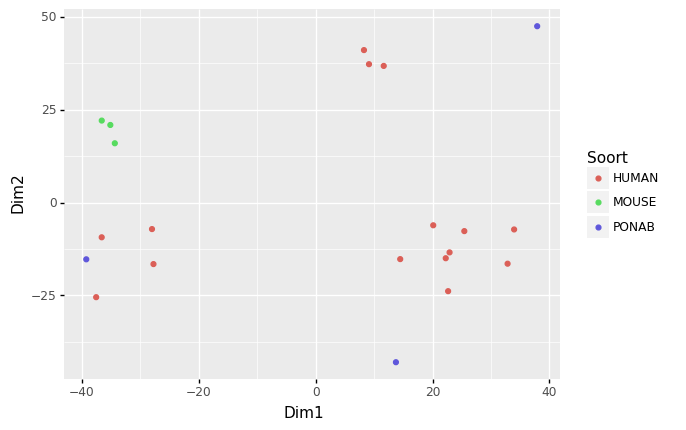

<ggplot: (-9223371915578553436)>

In [29]:
#plotnine
df_mds=pd.DataFrame()
df_mds['Dim1']=pos[:, 0]
df_mds['Dim2']=pos[:, 1]
df_mds['Soort']=df['Soort'] #soort


(
ggplot(aes(x='Dim1', y='Dim2'), data=df_mds)
+ geom_point(aes(color='Soort'))
)

## 5. ILLUSTRATIE: t-SNE

*****

In de onderstaande sectie wordt het gebruik van t-SNE geïllustreerd.

**Stap 1: inladen data**

In [37]:
# inlezen data
url='https://raw.githubusercontent.com/ArneDeloose/Ugain_MachineLearning_DataVis/main/iris.csv'

df = pd.read_csv(url, sep = ";")
df.head()

,sepal length,sepal width,petal length,petal width,soort
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


**Stap 2: fit tsne**

In [38]:
X=np.array(df.loc[:, 'sepal length':'petal width']) #selecteer numerieke data
tsne = TSNE(n_components=2, n_iter=1000)
points = tsne.fit_transform(X)

**Stap 3: vorm om naar dataframe**

In [39]:
#omvormen naar dataframe
df_tsne=pd.DataFrame()
df_tsne['Dim1']=points[:, 0] #kolom 1
df_tsne['Dim2']=points[:, 1] #kolom 2
df_tsne['Soort']=df['soort'] #soort

**Stap 4: plot coordinaten**

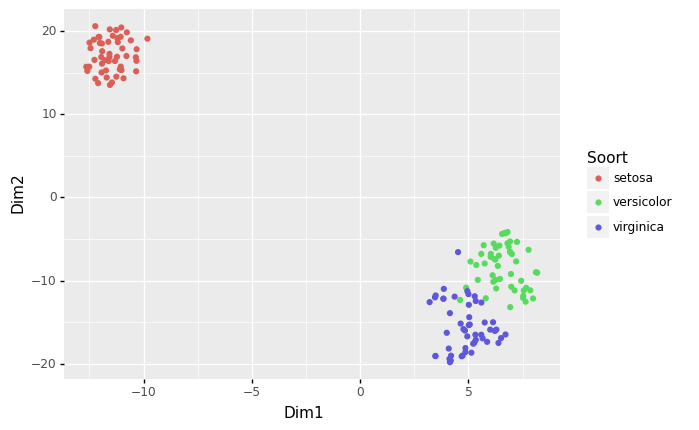

<ggplot: (-9223371947334077640)>

In [40]:
#met plotnine
(
ggplot(aes(x='Dim1', y='Dim2'), data=df_tsne)
+ geom_point(aes(color='Soort'))
)

## 6. ILLUSTRATIE: UMAP

*****

In de onderstaande sectie wordt het gebruik van UMAP (Uniform Manifold Approximation and Projection)  geïllustreerd.

**Stap 1: inladen UMAP en dataset**

In [15]:
!pip install umap-learn
#er is een andere module met dezelfde naam, dus je moet op deze manier importeren:
import umap.umap_ as umap 

# inlezen data
url='https://raw.githubusercontent.com/ArneDeloose/Ugain_MachineLearning_DataVis/main/iris.csv'

df = pd.read_csv(url, sep = ";")
df.head()

You should consider upgrading via the 'c:\users\adloose\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


,sepal length,sepal width,petal length,petal width,soort
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


**Stap 2: fit een reducer op de data (cfr. PCA)**

In [16]:
#via random_state kan je ervoor zorgen dat je 
#altijd hetzelfde resultaat krijgt als je de code opnieuw loopt
iris_array=np.array(df.loc[:, 'sepal length':'petal width']) #selecteer numerieke data
reducer = umap.UMAP(random_state=9000) 
reducer.fit(iris_array)

UMAP(random_state=9000, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

**Stap 3: gebruik de reduceren om de data te transformeren naar 2D coordinaten**

In [17]:
embedding = reducer.transform(iris_array)

#omvormen naar dataframe
df_umap=pd.DataFrame()
df_umap['Dim1']=embedding[:, 0] #kolom 1
df_umap['Dim2']=embedding[:, 1] #kolom 2
df_umap['Soort']=df['soort'] #soort

**Stap 4: plot de nieuwe coordinaten**

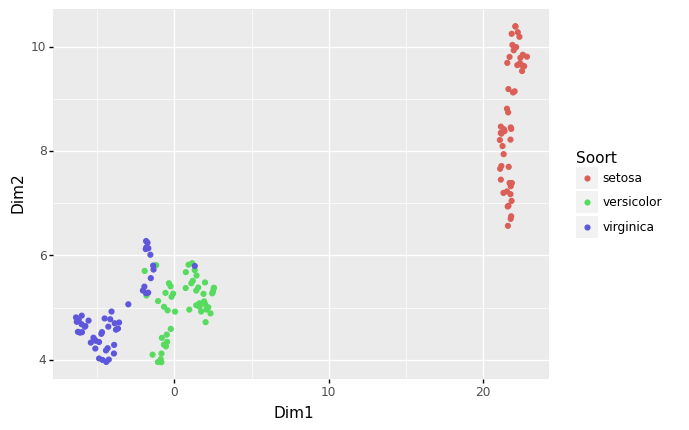

<ggplot: (-9223371947343866016)>

In [22]:
#met plotnine
(
ggplot(aes(x='Dim1', y='Dim2'), data=df_umap)
+ geom_point(aes(color='Soort'))
)